In [147]:
import sys
from pathlib import Path

# 시각화
import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR

In [148]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [149]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

milk: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
milk.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,공태일수,유량,질병군,우유등급,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,출생년도,PF비
0,21133,2.007121e+13,2021-03-18,445,6.60,3.28,8.87,274,11.6,15158.0,...,619,76169939,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.496970
1,21133,2.007121e+13,2021-04-28,486,3.64,3.33,8.91,166,11.0,15158.0,...,619,76170244,0,1등급,NaN,4.143135,4.330733,6.429719,2007,0.914835
2,21133,2.007121e+13,2021-05-20,508,2.61,3.35,9.14,156,10.8,15158.0,...,619,76170487,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.283525
3,21133,2.007121e+13,2021-06-25,544,3.75,3.49,8.99,307,14.1,15158.0,...,619,76170734,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.930667
4,21133,2.007121e+13,2021-07-07,556,3.68,3.74,9.31,34,16.2,15158.0,...,619,76170903,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.016304


In [150]:
bins = [15000000, 60000000]

# milk['유량구간'] = []

low_milk = milk[milk['유량'] <= 40000000]
high_milk = milk[milk['유량'] > 40000000]

In [151]:
df = milk

In [152]:
df.shape

(58441, 41)

In [153]:
df.info() # nan값은 pipeline으로 처리할 예정.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58441 entries, 0 to 58440
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   농장아이디         58441 non-null  int64         
 1   개체번호          58441 non-null  float64       
 2   검정일자          58441 non-null  datetime64[ns]
 3   누적착유일(연계)     58441 non-null  int64         
 4   유지방율          42084 non-null  float64       
 5   유단백           42084 non-null  float64       
 6   무지고형분         42084 non-null  float64       
 7   체세포수          58441 non-null  int64         
 8   MUN           42084 non-null  float64       
 9   305일유량        43678 non-null  float64       
 10  305일유지량       43678 non-null  float64       
 11  305일유단백       43678 non-null  float64       
 12  305일무지고형분     43678 non-null  float64       
 13  성년유량          43678 non-null  float64       
 14  성년유지량         43678 non-null  float64       
 15  성년유단백량        43678 non-null  float6

In [154]:
df.describe()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,농후사료급여량(연계),공태일수,유량,질병군,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,출생년도,PF비
count,58441.000000,5.844100e+04,58441,58441.000000,42084.000000,42084.000000,42084.000000,58441.000000,42084.000000,43678.000000,...,58441.000000,58441.000000,5.844100e+04,58441.000000,0.0,58440.000000,33724.000000,58441.000000,58441.000000,41919.000000
mean,20934.352663,2.016493e+13,2020-12-23 08:15:58.997963776,202.230643,4.170827,3.313077,8.838642,126.464845,14.392603,10720.070104,...,0.261529,124.274516,4.707034e+07,0.001044,NaN,4.355995,3.808339,3.464868,2016.334816,0.831584
min,20249.000000,2.007121e+13,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,755.000000,...,0.000000,0.000000,1.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000,2006.000000,0.217631
25%,20269.000000,2.015121e+13,2020-07-08 00:00:00,76.000000,3.630000,3.080000,8.580000,0.000000,11.900000,9384.000000,...,0.000000,0.000000,1.589173e+07,0.000000,NaN,3.912023,3.931826,0.000000,2015.000000,0.721709
50%,21137.000000,2.017042e+13,2020-12-21 00:00:00,188.000000,4.140000,3.300000,8.870000,38.000000,13.900000,10650.000000,...,0.000000,99.000000,6.066701e+07,0.000000,NaN,4.369448,4.077537,4.605170,2017.000000,0.805419
75%,21278.000000,2.018041e+13,2021-06-11 00:00:00,303.000000,4.680000,3.540000,9.150000,111.000000,16.500000,12035.000000,...,1.000000,193.000000,7.617652e+07,0.000000,NaN,4.875197,4.204693,5.267858,2018.000000,0.895151
max,21876.000000,2.021010e+13,2022-02-04 00:00:00,1101.000000,9.990000,8.900000,13.930000,20484.000000,57.200000,21284.000000,...,1.000000,974.000000,9.583738e+07,1.000000,NaN,6.643790,6.513230,6.882437,2020.000000,4.837838
std,585.808734,1.935616e+10,NaN,150.494690,0.960408,0.413767,0.709344,381.293975,3.789614,2031.349473,...,0.439471,126.059024,3.055409e+07,0.032291,NaN,0.819051,1.158737,2.370168,1.880170,0.209850


In [155]:
df['1등급'] = df['우유등급'].map({
    '1등급': 1,
    '2등급이하': 0
})

In [156]:
features = ['누적착유일(연계)', '전산차비유지속성', '현재산차비유지속성', '비유최고도달일수_log',
'건유전마지막유량_log', '전산차건유전유량', '출생년도', '산차', '농후사료비(연계)',
'농후사료급여량(연계)', '공태일수_log']

target = '1등급'

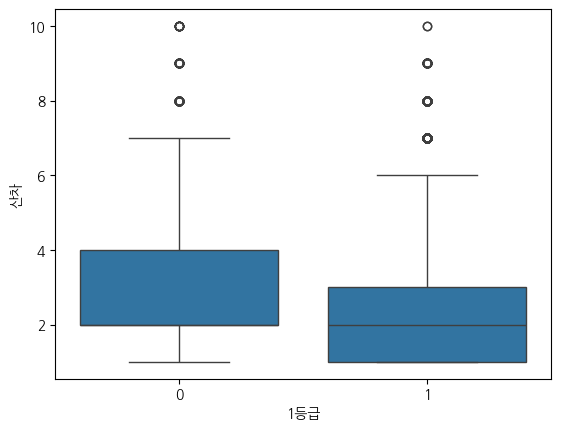

In [157]:
sns.boxplot(df, x=target, y='산차') # 우유등급별로 다른 결측치 처리를 해야겠음.
plt.show()

# 변수들 간의 상관관계 확인해서 review_score, monthly_avg_orders와 상관계수 높은 것들은 제거하거나 처리

In [158]:
vars = features + [target]
corr_matrix = df[vars].corr('spearman').round(3)

fig_corr = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Matrix (Plotly)",
    template="plotly_dark"
)
fig_corr.update_layout(
    xaxis_title="Features",
    yaxis_title="Features",
    width=1200, height=1000
)
fig_corr.show()



In [159]:
# 농후사료급여량, 산차 살림
features.remove('농후사료비(연계)')
features.remove('출생년도')

features

['누적착유일(연계)',
 '전산차비유지속성',
 '현재산차비유지속성',
 '비유최고도달일수_log',
 '건유전마지막유량_log',
 '전산차건유전유량',
 '산차',
 '농후사료급여량(연계)',
 '공태일수_log']

In [160]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[features].dropna()

vif_data = pd.DataFrame({
    "Feature": features,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

fig_vif = px.bar(
    vif_data.sort_values("VIF", ascending=True),
    x="VIF",
    y="Feature",
    orientation="h",
    title="Variance Inflation Factor (VIF) — 다중공선성 진단",
    template="plotly_dark",
    color="VIF",
    color_continuous_scale="Viridis"
)
fig_vif.add_vline(x=5, line_dash="dash", line_color="orange",
                  annotation_text="주의 경계선 (VIF=5)")
fig_vif.add_vline(x=10, line_dash="dot", line_color="red",
                  annotation_text="심각 (VIF=10)")
fig_vif.show()

In [161]:
# 비유최고도달일수_log 제거
features.remove('비유최고도달일수_log')

# 피어슨, 스피어만 상관분석

In [162]:
from scipy.stats import spearmanr


for feature in features:
    print('='*50)
    print(f'{feature}와 {target} 상관분석')
    print('='*50)
    
    temp = df.dropna(subset=[feature])
    r, pval = spearmanr(temp[target], temp[feature])
    print(f"Pearson correlation: r = {r:.3f}, p-value = {pval:.5f}")
    abs_r = abs(r)
    
    if abs_r < 0.1:
        effect = '매우 작은 효과'
    elif abs_r < 0.2:
        effect = '작은 효과'
    elif abs_r < 0.4:
        effect = '중간 효과'
    elif abs_r < 0.6:
        effect = '비교적 큰 효과'
    elif abs_r < 0.8:
        effect = '큰 효과'
    else:
        effect = '매우 큰 효과'
    print(effect)
    
    print()

누적착유일(연계)와 1등급 상관분석
Pearson correlation: r = -0.084, p-value = 0.00000
매우 작은 효과

전산차비유지속성와 1등급 상관분석
Pearson correlation: r = -0.075, p-value = 0.00000
매우 작은 효과

현재산차비유지속성와 1등급 상관분석
Pearson correlation: r = -0.016, p-value = 0.00015
매우 작은 효과

건유전마지막유량_log와 1등급 상관분석
Pearson correlation: r = -0.041, p-value = 0.00000
매우 작은 효과

전산차건유전유량와 1등급 상관분석
Pearson correlation: r = 0.043, p-value = 0.00000
매우 작은 효과

산차와 1등급 상관분석
Pearson correlation: r = -0.153, p-value = 0.00000
작은 효과

농후사료급여량(연계)와 1등급 상관분석
Pearson correlation: r = -0.002, p-value = 0.55798
매우 작은 효과

공태일수_log와 1등급 상관분석
Pearson correlation: r = -0.055, p-value = 0.00000
매우 작은 효과



# df train/test로 분리해야 함

In [163]:
df[target].value_counts()

1등급
1    50055
0     8386
Name: count, dtype: int64

In [164]:
df['검정일자'].dt.year.value_counts()

검정일자
2020    30075
2021    28298
2022       68
Name: count, dtype: int64

In [165]:
train = df[df['검정일자'].dt.year == 2020]
test = df[df['검정일자'].dt.year == 2021]

In [166]:
X_train, X_test = train[features], test[features]
y_train, y_test = train['1등급'], test['1등급']

# Pipeline 만들고 GridSearchCV 적용해서 best model 찾기!

SMOTE도 해보기

# 튜터님 조언: 단순 복제 oversampling 사용

In [167]:
from imblearn.over_sampling import RandomOverSampler

## RF

## LightGBM

In [172]:
import lightgbm as lgb
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


RandomOverSampler 사용

In [169]:
(y_train == 1).sum()

np.int64(26393)

In [170]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(0.13950668737922933)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# ============================================
# 1. 클래스 비율 확인
# ============================================
print("="*60)
print("클래스 분포 분석")
print("="*60)
print(y_train.value_counts())
print(f"\n비율:")
print(y_train.value_counts(normalize=True))

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n계산된 scale_pos_weight: {scale_pos_weight:.2f}")


# ============================================
# 2. 파라미터 그리드 (축소 버전)
# ============================================
# lgbm_param_grid = {
#     'n_estimators': [300, 500],              # 3→2 (early stopping 대신)
#     'learning_rate': [0.01, 0.05, 0.1],      # 유지
#     'max_depth': [3, 5, 7],                  # 유지
#     'num_leaves': [31, 50],                  # 3→2
#     'min_child_samples': [20, 50],           # 3→2
#     'subsample': [0.8, 1.0],                 # 유지
#     'colsample_bytree': [0.8, 1.0],          # 유지
#     'scale_pos_weight': [scale_pos_weight]   # 🔥 계산된 값 1개만 사용
# }

lgbm_param_grid = {
    'smote__sampling_strategy': [0.3, 0.5, 1.0],  # 소수:다수 비율
    'smote__k_neighbors': [3, 5, 7],              # 이웃 개수
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [3, 5, 7]
    # scale_pos_weight는 제거 (SMOTE가 균형 맞춤)
}


# 조합 수 계산
param_combinations = list(ParameterGrid(lgbm_param_grid))
n_combinations = len(param_combinations)
print(f"\n전체 파라미터 조합 수: {n_combinations}개")
# 2 × 3 × 3 × 2 × 2 × 2 × 2 × 1 = 288개 (훨씬 현실적)

# ============================================
# 3. Scoring 설정
# ============================================
scoring = {
    'pr_auc': 'average_precision',  # 주 목표
    # 'recall': 'recall',
    # 'precision': 'precision',
    # 'f1': 'f1',
    # 'roc_auc': 'roc_auc'
}

# ============================================
# 4. Stratified K-Fold
# ============================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_folds = 5

print(f"교차검증 Folds: {n_folds}")
print(f"총 Fits: {n_combinations} × {n_folds} = {n_combinations * n_folds}")

# ============================================
# 5. 시간 예측
# ============================================
print("\n" + "="*60)
print("⏱️  예상 시간 계산 중...")
print("="*60)

# 샘플 모델로 시간 측정
sample_model = LGBMClassifier(
    **param_combinations[0],
    objective='binary',
    random_state=42,
    device='gpu',  # CPU면 'cpu'로 변경
    verbosity=-1
)

start_time = time.time()
_ = cross_val_score(
    sample_model, X_train, y_train,
    cv=cv,
    scoring='average_precision',
    n_jobs=1  # 시간 측정용
)
sample_time = time.time() - start_time

# 예상 시간 계산
import os
n_cores = os.cpu_count() or 4
estimated_sequential = sample_time * n_combinations
estimated_parallel = estimated_sequential / min(n_cores, n_folds)

print(f"샘플 조합 소요 시간: {sample_time:.1f}초")
print(f"예상 총 시간 (순차): {estimated_sequential/60:.1f}분")
print(f"예상 총 시간 (병렬, {n_cores}코어): {estimated_parallel/60:.1f}분")

# 예상 완료 시각
estimated_finish = time.time() + estimated_parallel
print(f"\n💡 예상 완료 시각: {time.strftime('%H:%M:%S', time.localtime(estimated_finish))}")

# 사용자 확인
if estimated_parallel > 1800:  # 30분 이상
    print(f"\n⚠️  예상 시간이 {estimated_parallel/60:.0f}분으로 깁니다.")
    print("   RandomizedSearchCV 사용을 고려하세요.")
    proceed = input("   계속 진행하시겠습니까? (y/n): ")
    if proceed.lower() != 'y':
        print("중단되었습니다.")
        raise SystemExit

# ============================================
# 6. LightGBM 모델 정의
# ============================================
pipeline = ImbPipeline([
    ('impute', SimpleImputer())
    ('smote', SMOTE(random_state=42)),
    ('model', LGBMClassifier(
        objective='binary',
        device='gpu',
        random_state=42,
        verbosity=-1
    ))
])

# ============================================
# 7. GridSearchCV 실행 (프로그레스바 포함)
# ============================================
print("\n" + "="*60)
print("🚀 GridSearchCV 시작!")
print("="*60)

lgbm_grid = GridSearchCV(
    pipeline,
    lgbm_param_grid,
    cv=cv,
    scoring='average_precision',
    verbose=2,
    n_jobs=-1
)
# 실제 실행 시간 측정
start_actual = time.time()
lgbm_grid.fit(X_train, y_train)
actual_time = time.time() - start_actual

print(actual_time)

클래스 분포 분석
1등급
1    26393
0     3682
Name: count, dtype: int64

비율:
1등급
1    0.877573
0    0.122427
Name: proportion, dtype: float64

계산된 scale_pos_weight: 0.14

전체 파라미터 조합 수: 243개
교차검증 Folds: 5
총 Fits: 243 × 5 = 1215

⏱️  예상 시간 계산 중...
샘플 조합 소요 시간: 2.0초
예상 총 시간 (순차): 8.1분
예상 총 시간 (병렬, 64코어): 1.6분

💡 예상 완료 시각: 14:26:55

🚀 GridSearchCV 시작!
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2

[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote__sampling_strategy=0.3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__num_leaves=31, smote__k_neighbors=3, smote_

ValueError: 
All the 1215 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/pipeline.py", line 440, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/pipeline.py", line 1336, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/base.py", line 202, in fit_resample
    return super().fit_resample(X, y, **params)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/base.py", line 99, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/imblearn/base.py", line 157, in _check_X_y
    X, y = validate_data(self, X=X, y=y, reset=True, accept_sparse=accept_sparse)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1105, in check_array
    _assert_all_finite(
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [59]:

# ============================================
# 8. 결과 출력
# ============================================
print("\n" + "="*60)
print("✅ 완료!")
print("="*60)
print(f"⏱️  실제 소요 시간: {actual_time/60:.1f}분")
print(f"   (예상 대비: {actual_time/estimated_parallel*100:.0f}%)")

print(f"\n🏆 최고 PR-AUC: {lgbm_grid.best_score_:.4f}")

print("\n📋 최적 파라미터:")
for key, value in lgbm_grid.best_params_.items():
    print(f"   {key}: {value}")

# ============================================
# 9. 전체 결과 비교 (상위 10개)
# ============================================
results_df = pd.DataFrame(lgbm_grid.cv_results_)

print(results_df)
comparison_cols = [
    # 'rank_test_pr_auc',
    # 'mean_test_pr_auc',
    # 'mean_test_recall',
    # 'mean_test_precision',
    'mean_test_f1',
    # 'mean_test_roc_auc',
    'params'
]

print("\n" + "="*60)
print("📊 상위 10개 파라미터 조합")
print("="*60)
top_10 = results_df[comparison_cols].sort_values('rank_test_pr_auc').head(10)
print(top_10.to_string(index=False))

# ============================================
# 10. 테스트 세트 평가
# ============================================
print("\n" + "="*60)
print("🧪 테스트 세트 평가")
print("="*60)

best_model = lgbm_grid.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['0 (다수)', '1 (소수)']))

print("\n혼동 행렬:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['실제_0', '실제_1'],
                     columns=['예측_0', '예측_1'])
print(cm_df)

# 비즈니스 해석
tn, fp, fn, tp = cm.ravel()
print("\n💼 비즈니스 해석:")
print(f"   ✅ 정확한 분류: {tn + tp}개 ({(tn+tp)/len(y_test)*100:.1f}%)")
print(f"   ⚠️  오탐 (0→1): {fp}개")
print(f"   🚨 미탐 (1→0): {fn}개 ← 소수 클래스 놓침!")
print(f"   📊 Recall (소수 클래스): {tp/(tp+fn)*100:.1f}%")

# ============================================
# 11. 모델 저장 (선택 사항)
# ============================================
# import joblib
# joblib.dump(best_model, 'best_lgbm_model.pkl')
# print("\n💾 모델 저장 완료: best_lgbm_model.pkl")


✅ 완료!
⏱️  실제 소요 시간: 0.1분
   (예상 대비: 549%)

🏆 최고 PR-AUC: 0.3473

📋 최적 파라미터:
   colsample_bytree: 1.0
   learning_rate: 0.1
   max_depth: 5
   min_child_samples: 20
   n_estimators: 100
   num_leaves: 31
   scale_pos_weight: 7.16811515480717
   subsample: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.300430      0.003991         0.003622        0.000178   
1       0.302539      0.003968         0.004058        0.000290   

   param_colsample_bytree  param_learning_rate  param_max_depth  \
0                     1.0                 0.05                5   
1                     1.0                 0.10                5   

   param_min_child_samples  param_n_estimators  param_num_leaves  ...  \
0                       20                 100                31  ...   
1                       20                 100                31  ...   

   param_subsample                                             params  \
0              1.0  {'colsample_bytree': 1.0

KeyError: "['mean_test_f1'] not in index"

In [ ]:
import joblib
from utils import MODEL_DIR

# 모델 저장
best_model = lgbm_grid.best_estimator_
lgbm_path = MODEL_DIR / 'best_lgbm_model.pkl'
joblib.dump(best_model, lgbm_path)
print(f'LGBM 최적 모델 저장 완료: {lgbm_path}')

In [ ]:
# 3. XGBoost 설정 (불균형 특화)
xgb_param_grid = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 10, 50, 100]  # 소수 클래스 가중치
}


# 7. XGBoost 실험
print("\n" + "="*60)
print("XGBoost 실험 중...")
print("="*60)

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    tree_method='hist',  # 빠른 학습
    early_stopping_rounds=50,
    device='gpu',
)

xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring=scoring,
    refit='auc',
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

In [ ]:
# 8. 결과 비교 및 분석
print("\n" + "="*60)
print("최종 결과 비교")
print("="*60)

results = []

for name, grid in [('LightGBM', lgbm_grid), ('XGBoost', xgb_grid)]:
    best_idx = grid.best_index_
    results.append({
        'Model': name,
        'AUC': f"{grid.cv_results_['mean_test_auc'][best_idx]:.4f}",
        'F1': f"{grid.cv_results_['mean_test_f1'][best_idx]:.4f}",
        'Precision': f"{grid.cv_results_['mean_test_precision'][best_idx]:.4f}",
        'Recall': f"{grid.cv_results_['mean_test_recall'][best_idx]:.4f}",
        'AP': f"{grid.cv_results_['mean_test_ap'][best_idx]:.4f}",
        'Best Params': grid.best_params_
    })

results_df = pd.DataFrame(results)
print(results_df)

# 9. 최종 모델 선택
if lgbm_grid.best_score_ > xgb_grid.best_score_:
    best_model = lgbm_grid.best_estimator_
    best_name = "LightGBM"
else:
    best_model = xgb_grid.best_estimator_
    best_name = "XGBoost"

print(f"\n🏆 최종 선택: {best_name}")
print(f"Best AUC: {max(lgbm_grid.best_score_, xgb_grid.best_score_):.4f}")

# 10. 테스트 세트 평가 (있다면)
if 'X_test' in locals() and 'y_test' in locals():
    from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
    
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    print("\n테스트 세트 성능:")
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"AP: {average_precision_score(y_test, y_pred_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

## 임시

In [56]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


# Pipeline 구성 (RandomOverSampler + LightGBM)
pipeline = Pipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        device='gpu',
        random_state=42,
        verbosity=-1
    ))
])

param_grid = {
    'clf__n_estimators': [300],
    'clf__max_depth': [5],
    'clf__learning_rate': [0.05],
    'clf__min_child_samples': [1],
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV 설정
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    # refit='f1_macro',  # 최종 모델은 f1_macro 기준 선택
    cv=5,
    # n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.8s


,estimator,Pipeline(step...rbosity=-1))])
,param_grid,"{'clf__learning_rate': [0.05], 'clf__max_depth': [5], 'clf__min_child_samples': [1], 'clf__n_estimators': [300]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [57]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.75761      0.019136         0.004887        0.000214   

   param_clf__learning_rate  param_clf__max_depth  \
0                      0.05                     5   

   param_clf__min_child_samples  param_clf__n_estimators  \
0                             1                      300   

                                              params  split0_test_score  \
0  {'clf__learning_rate': 0.05, 'clf__max_depth':...           0.198034   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.252456           0.366801           0.451049           0.534319   

   mean_test_score  std_test_score  rank_test_score  
0         0.360532         0.12371                1  

Best params (기준: f1_macro): {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__min_child_samples': 1, 'clf__n_estimators': 300}
Best f1_macro score: 0.3605319049129708


In [58]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.240     0.571     0.338      4698
           1      0.882     0.640     0.742     23600

    accuracy                          0.629     28298
   macro avg      0.561     0.606     0.540     28298
weighted avg      0.776     0.629     0.675     28298


Balanced Accuracy (Test Set): 0.606
ROC-AUC (OvO, macro, Test Set): 0.644


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

scale_pos_weight 사용

In [ ]:
from collections import Counter

counter = Counter(y_train)
print(counter)

# 기준 클래스 (다수 클래스)
major_class = 'group_0'
major_count = counter[major_class]

# scale_pos_weight 계산
scale_pos_weight = {cls: round(major_count / count, 2) for cls, count in counter.items()}
print(scale_pos_weight)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(counter),
    class_weight='scale_pos_weight',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [1, 5, 10],
    'min_gain_to_split': [0, 0.01, 0.05]
}

# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## class_weight='balanced', 하이퍼파라미터 튜닝 변경

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight='balanced',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

randomoversampler 일부만, class_weight, 하이퍼파라미터 튜닝

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 일부만 RandomOverSampler 적용
# 소수 클래스 target 샘플 수 직접 지정
sampling_strategy = {
    'group_1': 1000,  # group_1 샘플 증가
    'else': 1000      # else 샘플 증가
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# LightGBM 파이프라인
pipeline = Pipeline([
    ('oversample', ros),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        is_unbalance=True,
        class_weight='balanced',
        num_class=3,
        random_state=42
    ))
]) # 분류 모델의 클래스 threshold 조정하여 낮은 확률이더라도 맞출 수 있도록 하기.

# 하이퍼파라미터 그리드
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [10, 20],
    'clf__learning_rate': [0.01, 0.05],
    'clf__num_leaves': [31, 63, 127],
    'clf__min_child_samples': [1, 3, 5],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}

# 평가 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
    'average_precision_macro': 'average_precision_macro'
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='average_precision_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)


In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)  # shape = (n_samples, n_classes)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro') # <- 조정해도 값이 바뀔 수 없는 건가? 순서 기준으로 점수를 매겨서 임계값과
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

y_pred = np.array(y_pred)

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# SMOTE + LightGBM + class_weight + GridSearchCV

In [ ]:
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


# LightGBM classifier
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',  # 소수 클래스 가중치 자동 적용
    n_jobs=-1,
    device='cuda',
    random_state=42,
)

# GridSearchCV 파라미터
param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [10, 20],
    'model__learning_rate': [0.01, 0.05],
    'model__num_leaves': [31, 63, 127],
    'model__min_child_samples': [1, 3, 5],
    'model__min_gain_to_split': [0, 0.01, 0.05]
}

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('smote', SMOTE(random_state=42)),
    ('model', lgbm_clf)
])


scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=-1
)

# 학습
grid.fit(X_train, y_train)

# 결과 확인
print("Best params:", grid.best_params_)
print("Best f1_macro:", grid.best_score_)

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split i

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.905402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of positive: 17596, number of negative: 17596
[LightGBM] [Info] Number of positive: 17595, number of negative: 17595
[LightGBM] [Info] Number of positive: 17596, number of negative: 17596
[LightGBM] [Info] Number of data points in the train set: 35190, number of used features: 11
[LightGBM] [Info] Number of positive: 17595, number of negative: 17595
[LightGBM] [Info] Number of positive: 17595, number of negative: 17595
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Info] Number of positive: 17595, number of negative: 17595
[LightGBM] [Warning] min_gain_to_split 

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


[LightGBM] [Info] Number of data points in the train set: 35192, number of used features: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.030776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.300752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 35190, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.211734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0

: 

: 

In [ ]:
# 테스트 세트 예측
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

# 테스트셋 성능 평가
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

In [ ]:
best_model = grid.best_estimator_

In [ ]:
best_model.feature_importances_

In [ ]:
# SPLIT
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

# GAIN
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)

In [ ]:
best_model.booster_.save_model('/content/drive/MyDrive/꾸러기_수비대/lgbm_booster.txt')

In [ ]:
import pickle

# 저장
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# 불러오기
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [ ]:
# 예측
y_pred = loaded_clf.predict(X_test)